# Landsat Thermal Sharpening Example

In [1]:
import pprint

import ee
from IPython.display import Image

import openet.sharpen

# ee.Authenticate()
ee.Initialize()

viridis_palette = ['#440154', '#433982', '#30678D', '#218F8B', '#36B677', '#8ED542', '#FDE725']

image_size = 768


In [2]:
# landsat_id = 'LC08_044033_20170918'  # Cloudy, some clear areas over northern CV
landsat_id = 'LC08_042034_20180705'  # Clear
landsat_img = ee.Image(f'LANDSAT/LC08/C02/T1_L2/{landsat_id}')


In [3]:
site_xy = [-120.105, 36.95]
# site_xy = [-120.10237, 36.946608]
dx = 0.012
dy = 0.006
study_geom = ee.Geometry.Rectangle(site_xy[0]-dx, site_xy[1]-dy, site_xy[0]+dx, site_xy[1]+dy)
study_region = study_geom.bounds(1, 'EPSG:4326')


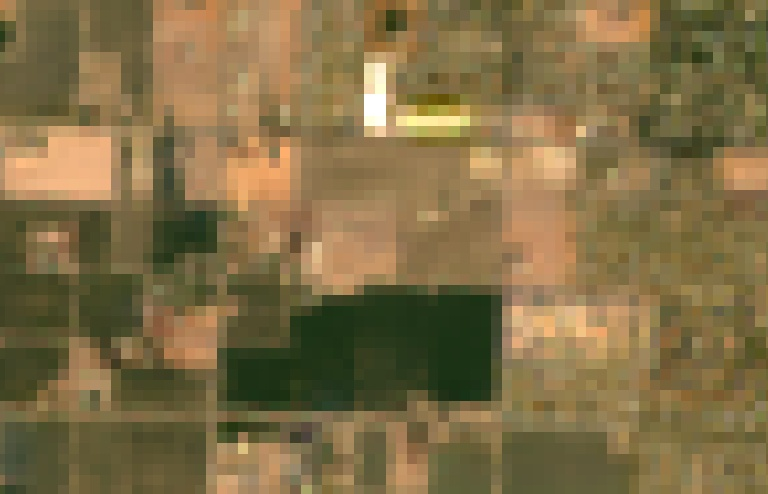

In [4]:
image_url = landsat_img.select([3, 2, 1]).multiply(0.0000275).add(-0.2)\
    .getThumbURL({'min': 0.0, 'max': 0.3, 
                  'dimensions':image_size, 'region': study_region})
Image(url=image_url, embed=True, format='png')


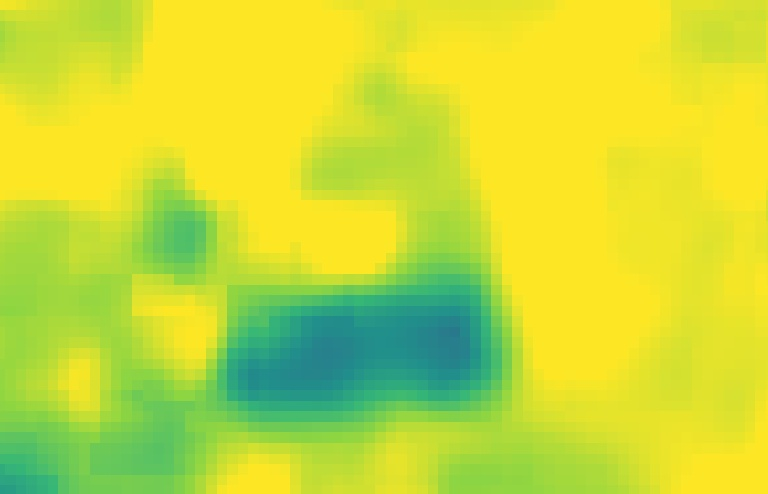

In [5]:
image_url = landsat_img.select(['ST_B10']).multiply(0.00341802).add(149.0)\
    .getThumbURL({'min': 295, 'max': 320, 'palette': viridis_palette,
                  'dimensions':image_size, 'region': study_region})
Image(url=image_url, embed=True, format='png')


## Prepare the Landsat image for sharpening

This primarily consists of standardizing the band names.

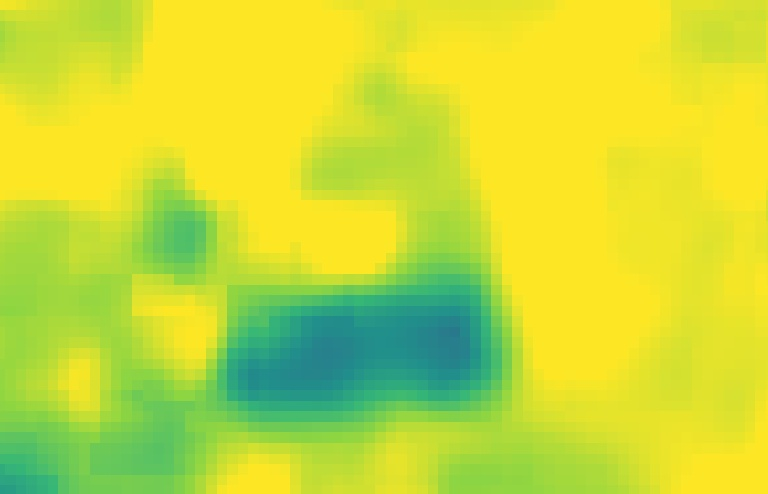

In [6]:
# CGM - The "SPACECRAFT_ID" property must be set on the image for the algorithm to work
input_bands = ee.Dictionary({
    'LANDSAT_5': ['SR_B1', 'SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B7', 'ST_B6', 'QA_PIXEL'],
    'LANDSAT_7': ['SR_B1', 'SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B7', 'ST_B6', 'QA_PIXEL'],
    'LANDSAT_8': ['SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B6', 'SR_B7', 'ST_B10', 'QA_PIXEL'],
    'LANDSAT_9': ['SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B6', 'SR_B7', 'ST_B10', 'QA_PIXEL'],
})
output_bands = ['blue', 'green', 'red', 'nir', 'swir1', 'swir2', 'tir', 'qa']
spacecraft_id = ee.String(landsat_img.get('SPACECRAFT_ID'))
prep_img = (
    landsat_img
    .select(input_bands.get(spacecraft_id), output_bands)
    .multiply([0.0000275, 0.0000275, 0.0000275, 0.0000275, 0.0000275, 0.0000275, 
               0.00341802, 1])
    .add([-0.2, -0.2, -0.2, -0.2, -0.2, -0.2, 149.0, 1])
    .set({'system:index': landsat_img.get('system:index'),
          'system:time_start': landsat_img.get('system:time_start'),
          'system:id': landsat_img.get('system:id'), 
          'SPACECRAFT_ID': spacecraft_id,
         })
)

image_url = prep_img.select(['tir'])\
    .getThumbURL({'min': 295, 'max': 320, 'palette': viridis_palette,
                  'dimensions':image_size, 'region': study_region})
Image(url=image_url, embed=True, format='png')


## Run the thermal sharpening

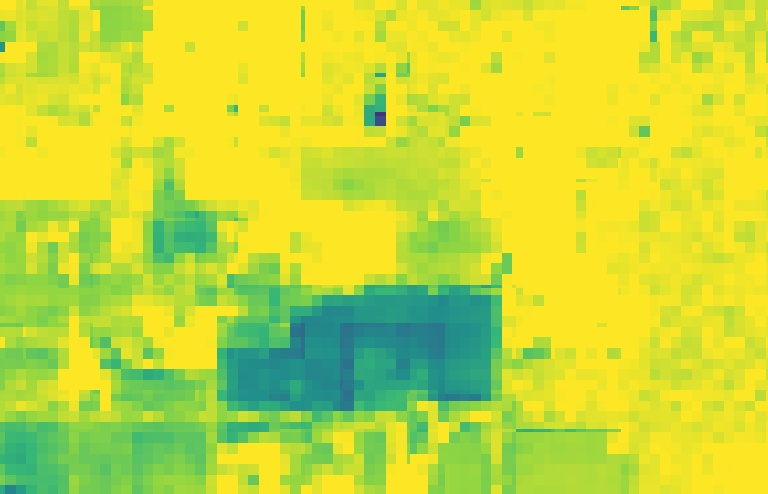

In [7]:
output_img = openet.sharpen.Model(prep_img).thermal()

image_url = output_img.select(['tir_sharpened'])\
    .getThumbURL({'min': 295, 'max': 320, 'palette': viridis_palette,
                  'dimensions':image_size, 'region': study_region})
Image(url=image_url, embed=True, format='png')


In [8]:
def point_image_value(image, xy, scale=1):
    """Extract the output value from a calculation at a point"""
    return ee.Image(image).reduceRegion(
        reducer=ee.Reducer.first(), geometry=ee.Geometry.Point(xy),
        scale=scale).getInfo()

pprint.pprint(point_image_value(prep_img.select(['tir']), site_xy, scale=1))
pprint.pprint(point_image_value(output_img.select(['tir_sharpened']), site_xy, scale=1))


{'tir': 321.44936306}
{'tir_sharpened': 321.1325220054726}
